To run an unsupervised classification on satellite data using Python you need GDAL, Numpy and Sklearn. If you wish to see the data you will also need Matplotlib. Assuming you have the libraries installed, import them at the start.
<br>
<br>
Lets start with a single band image

(9751, 11701)
(114096451, 1)
9751


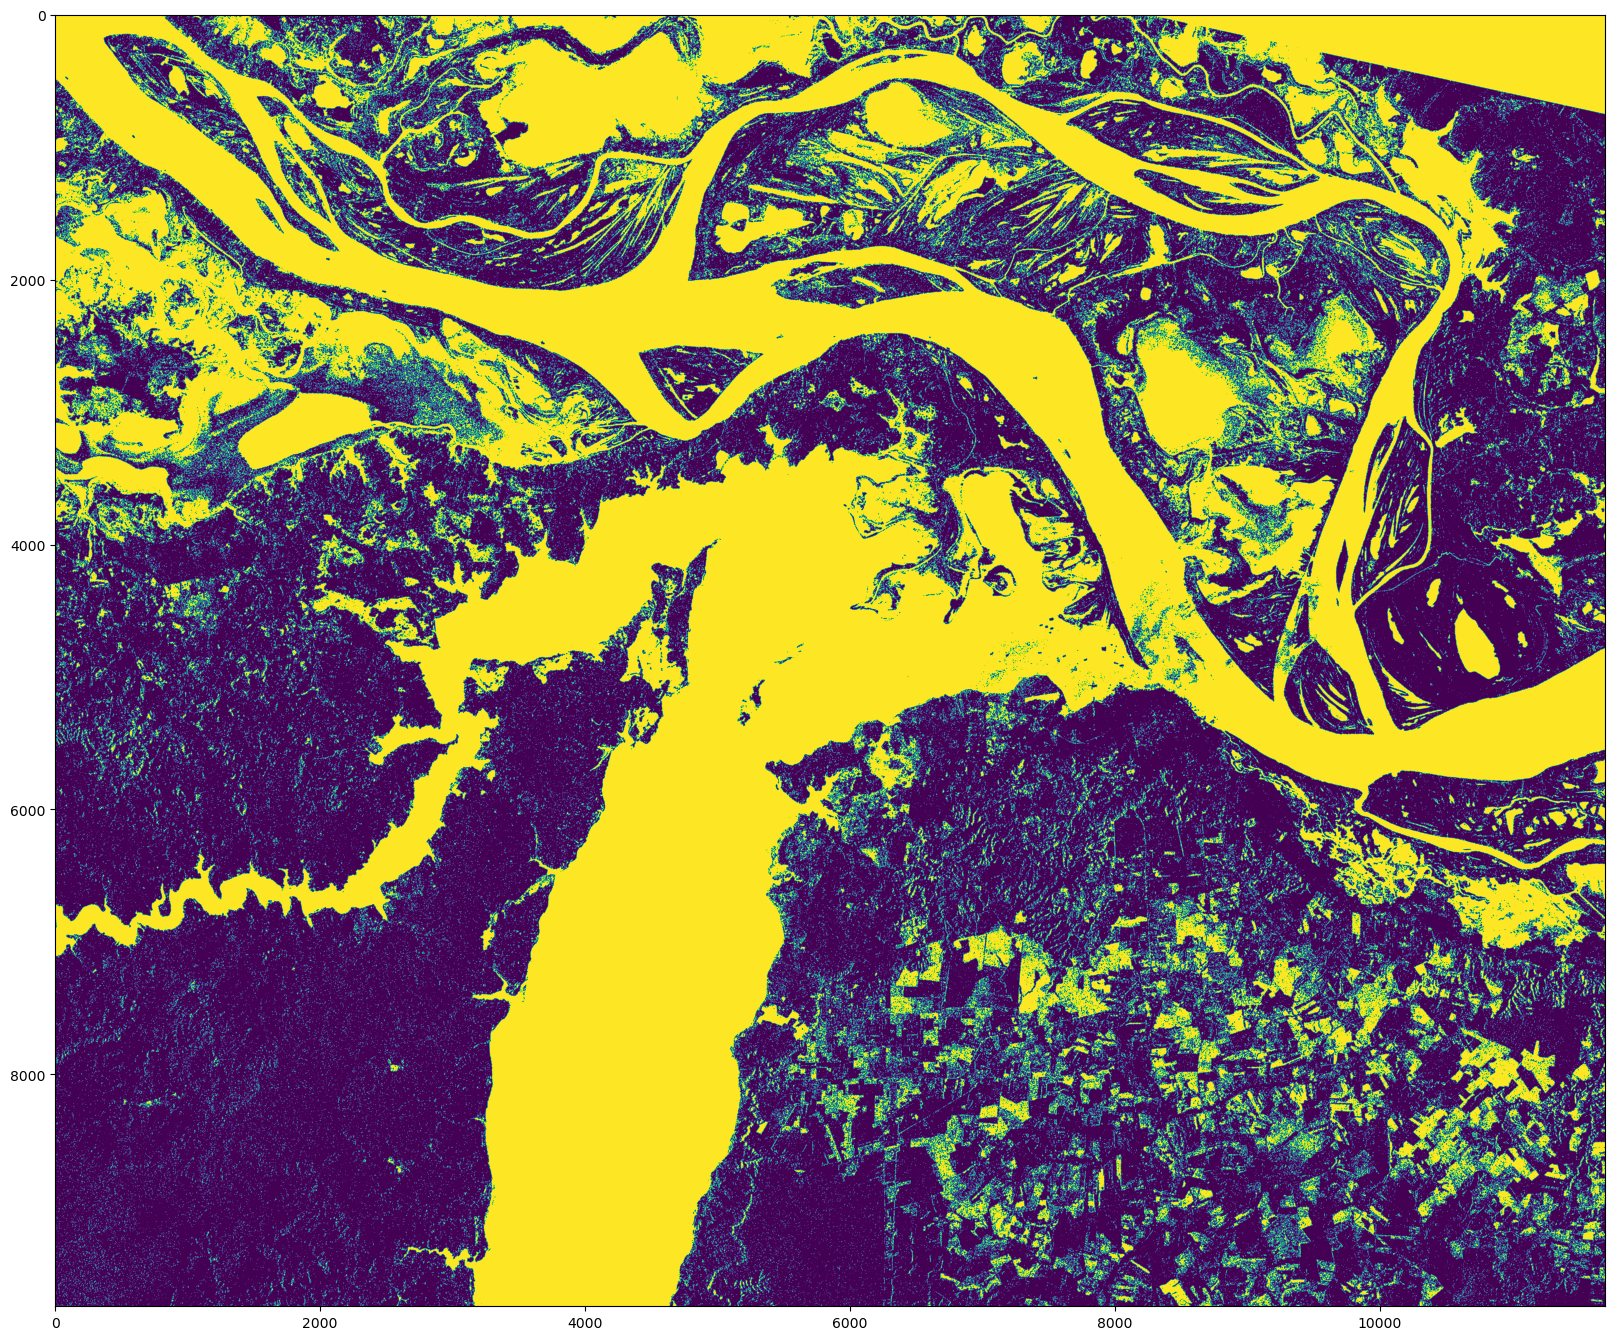

In [28]:
import numpy as np
from sklearn import cluster
from osgeo import gdal, gdal_array
import matplotlib.pyplot as plt
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image 
img_ds = gdal.Open("./subset_0_of_S1A_IW_GRDH_1SDV_20240113T092308_20240113T092333_052086_064B95_F370_Cal_Spk_TC.tif", gdal.GA_ReadOnly)

band = img_ds.GetRasterBand(2)

img = band.ReadAsArray()
print (img.shape)

X = img.reshape((-1,1))
print (X.shape)


k_means = cluster.KMeans(n_clusters=2)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img.shape)

print (len(X_cluster))


plt.figure(figsize=(20,20))
plt.imshow(X_cluster)

plt.show()



Plot the classified image

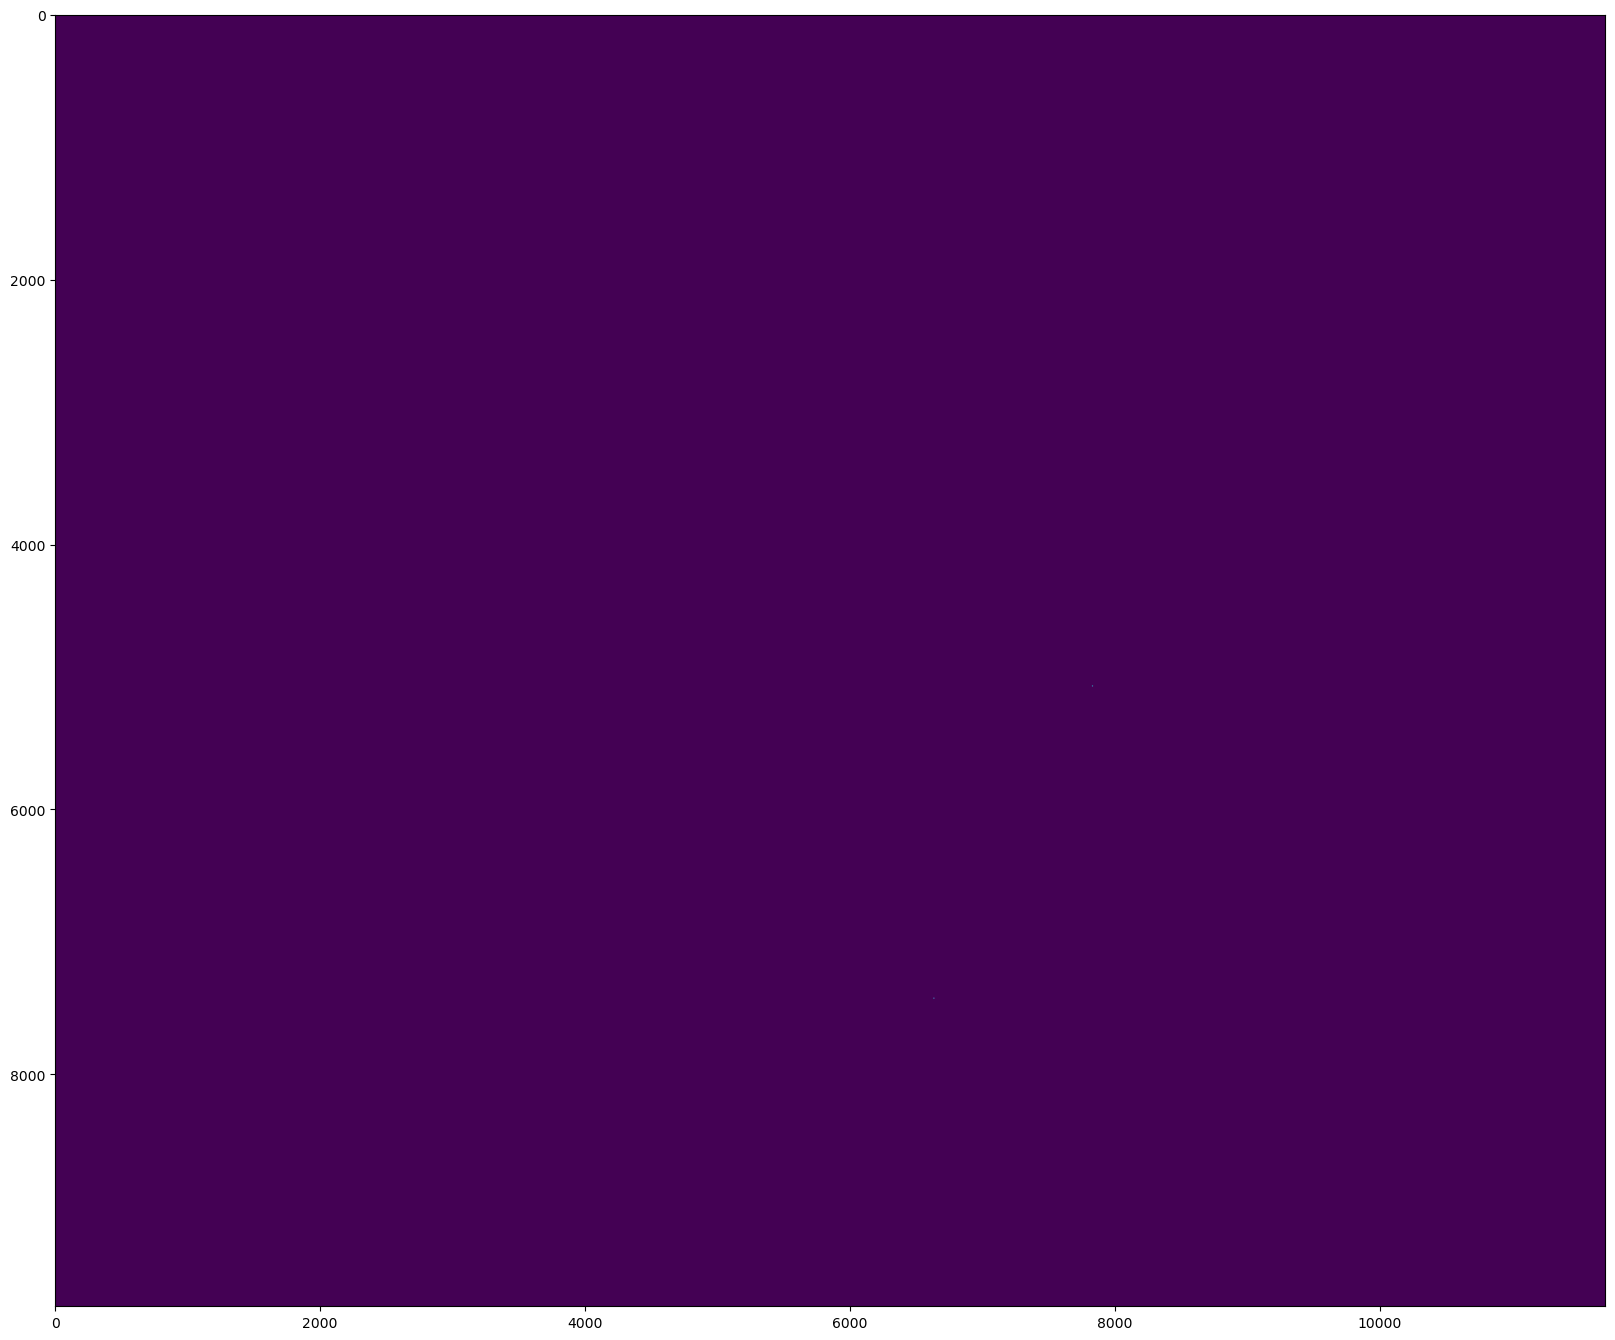

In [27]:
%matplotlib inline  

import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(X_cluster)

plt.show()
# plt.savefig("2cluster.png")

What about using all 13 bands of Sentinel 2?

In [29]:
import numpy as np
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image 
img_ds = gdal.Open('./subset_0_of_S1A_IW_GRDH_1SDV_20240113T092308_20240113T092333_052086_064B95_F370_Cal_Spk_TC.tif', gdal.GA_ReadOnly)


img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
print (img.shape)

print (new_shape)


X = img[:, :, :13].reshape(new_shape)

print (X.shape)

(9751, 11701, 4)
(114096451, 4)
(114096451, 4)


Now fit it

In [33]:
k_means = cluster.KMeans(n_clusters=3)
k_means.fit(X)

X_cluster = k_means.labels_


X_cluster = X_cluster.reshape(img[:, :, 0].shape)



And plot

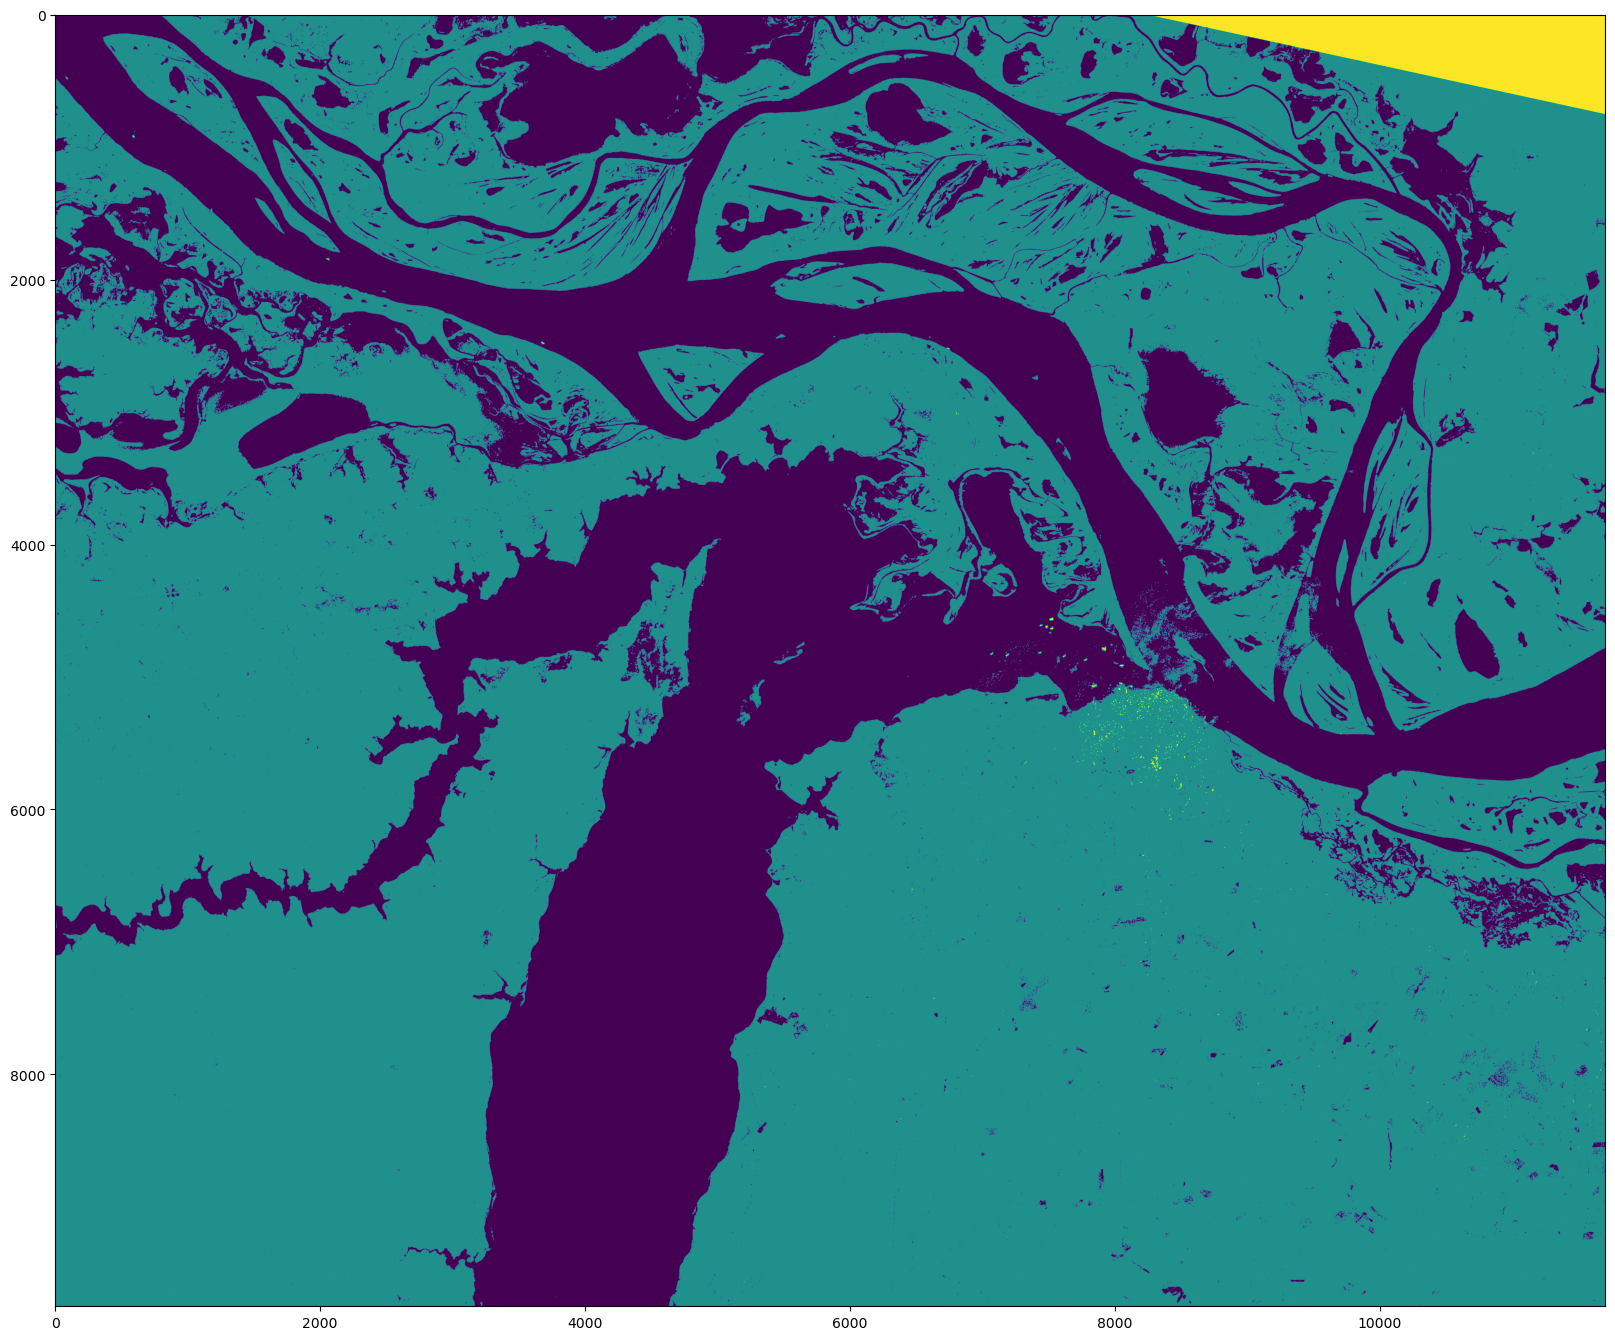

In [34]:
%matplotlib inline  

import matplotlib.pyplot as plt
# print (X_clustered.shape)

plt.figure(figsize=(20,20))
plt.imshow(X_cluster)

plt.show()

Changing the classification is straight forward. In this example choose MiniBatchKMeans

In [37]:
MB_KMeans = cluster.MiniBatchKMeans(n_clusters=3)
MB_KMeans.fit(X)

X_cluster = MB_KMeans.labels_


X_cluster = X_cluster.reshape(img[:, :, 0].shape)

c:\Users\Srinivasan M\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2560 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Plot the result

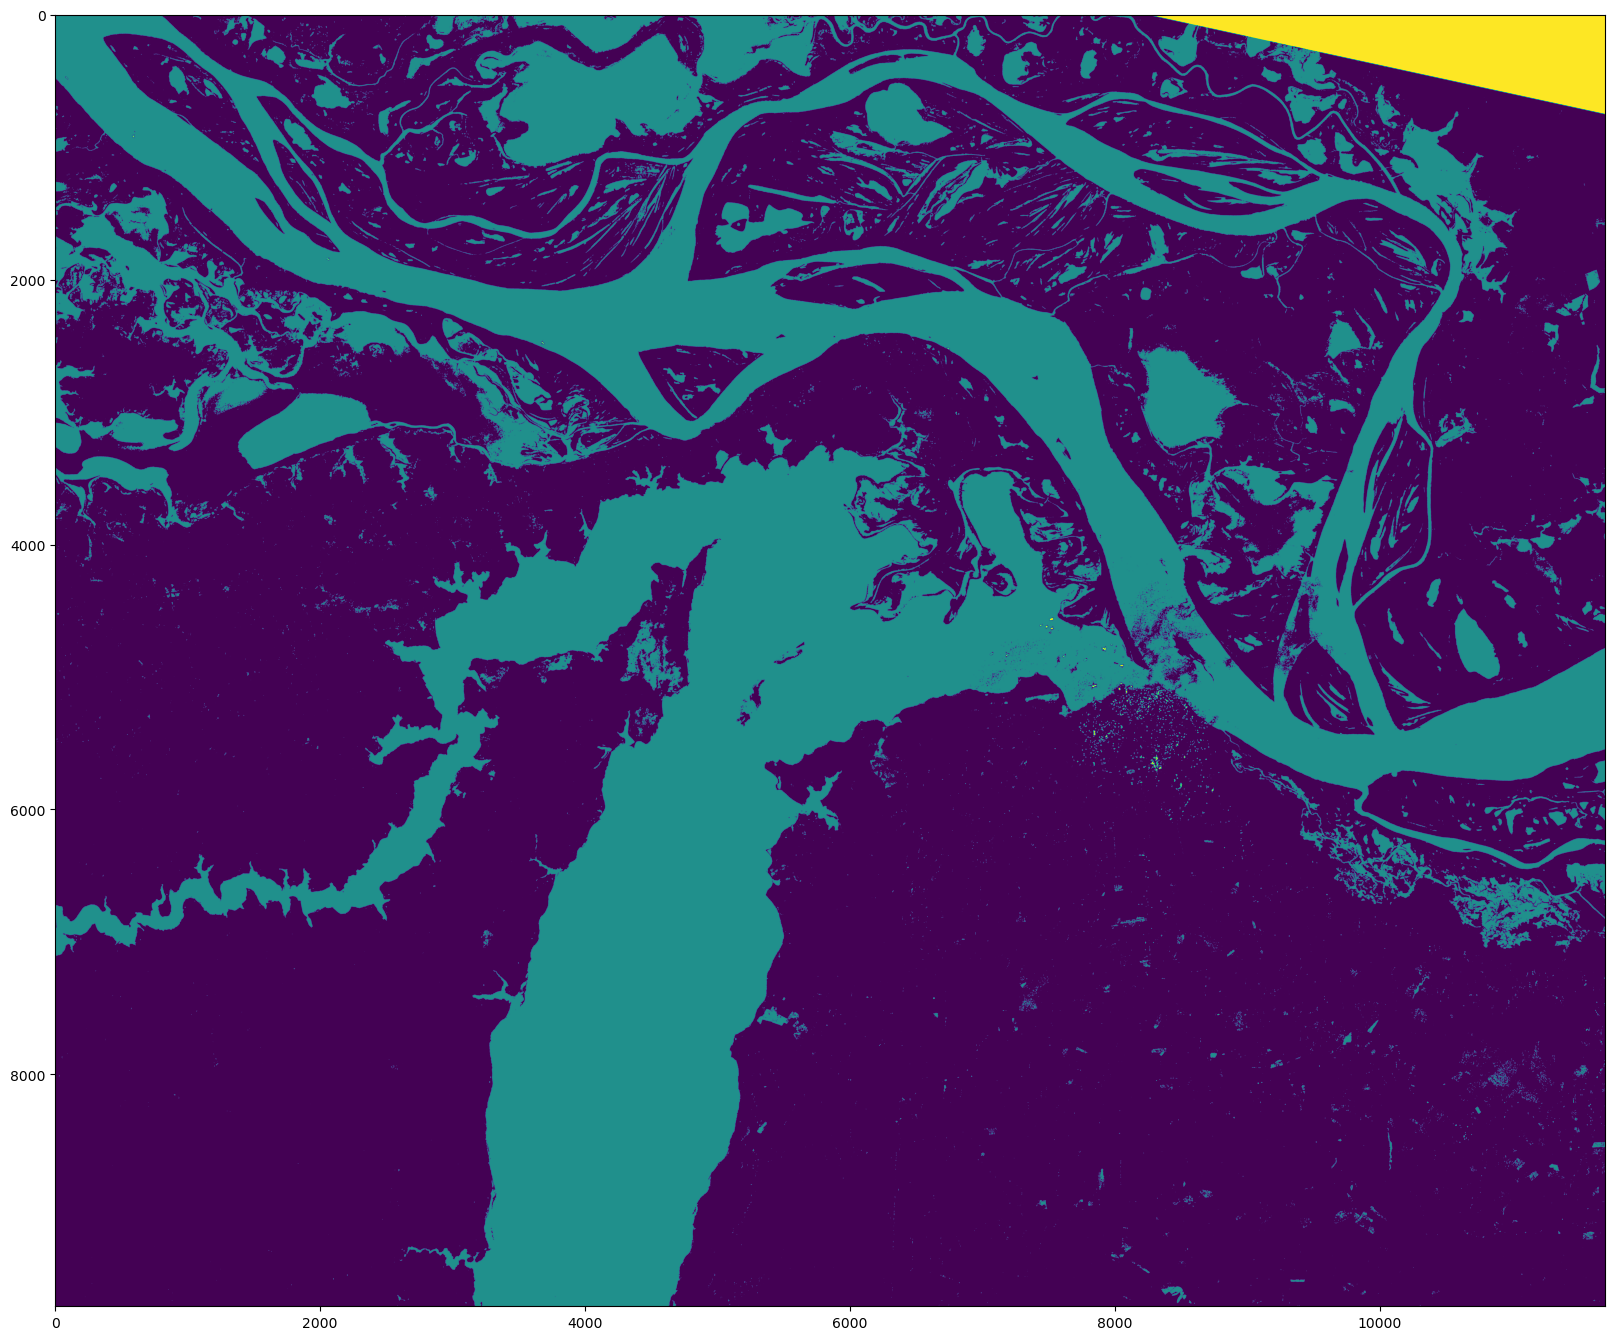

In [38]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster)

plt.show()

Final save the result to a bew geotiff

In [51]:
from osgeo import gdal, gdal_array
## write out to tiff
### single band raster. 

ds = gdal.Open(".../S2_may_South_coast_clip.tif")
band = ds.GetRasterBand(2)
arr = band.ReadAsArray()
[cols, rows] = arr.shape

format = "GTiff"
driver = gdal.GetDriverByName(format)


outDataRaster = driver.Create(".../k_means.gtif", rows, cols, 1, gdal.GDT_Byte)
outDataRaster.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outDataRaster.SetProjection(ds.GetProjection())##sets same projection as input


outDataRaster.GetRasterBand(1).WriteArray(X_cluster)

outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)